In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [50]:
helix_formers = {'A', 'L', 'M', 'E', 'Q', 'K'}
sheet_formers = {'V', 'I', 'Y', 'F', 'C', 'T', 'W'}
helix_breakers = {'P', 'G'}

In [51]:
def predict_secondary_structure(sequence):
    prediction = []
    for aa in sequence:
        if aa in helix_formers:
            prediction.append('H')  # Helix
        elif aa in sheet_formers:
            prediction.append('E')  # Sheet
        elif aa in helix_breakers:
            prediction.append('C')  # Coil
        else:
            prediction.append('C')  # Default to Coil
    return ''.join(prediction)


In [52]:
# Input sequences
sequences = ['ACDEFGHIK', 'LMNPQRSTY', 'ACDFGHIKL']

# Generate labels for each sequence
predicted_labels = [predict_secondary_structure(seq) for seq in sequences]

# Display results
for i, seq in enumerate(sequences):
    print(f"Sequence: {seq}")
    print(f"Predicted Labels: {predicted_labels[i]}")
    print()


Sequence: ACDEFGHIK
Predicted Labels: HECHECCEH

Sequence: LMNPQRSTY
Predicted Labels: HHCCHCCEE

Sequence: ACDFGHIKL
Predicted Labels: HECECCEHH



In [53]:


# Encode amino acids and labels
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
seq_encoded = [[aa_to_idx[aa] for aa in seq] for seq in sequences]
label_encoded = [[{'C': 0, 'H': 1, 'E': 2}[ss] for ss in label] for label in labels]


In [54]:
max_len = max(len(seq) for seq in seq_encoded)
X = tf.keras.preprocessing.sequence.pad_sequences(seq_encoded, maxlen=max_len)
y = tf.keras.preprocessing.sequence.pad_sequences(label_encoded, maxlen=max_len)


In [55]:
# One-hot encode labels
y = np.array([to_categorical(seq, num_classes=3) for seq in y])

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a simple LSTM model
model = Sequential([
    Embedding(input_dim=len(amino_acids), output_dim=16, input_length=max_len),
    LSTM(32, return_sequences=True),
    Dense(3, activation='softmax')  # 3 classes: C, H, E
])


In [56]:
# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=2)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5556 - loss: 1.0967 - val_accuracy: 0.6667 - val_loss: 1.0949
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6111 - loss: 1.0916 - val_accuracy: 0.5556 - val_loss: 1.0929
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7778 - loss: 1.0864 - val_accuracy: 0.5556 - val_loss: 1.0910
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7778 - loss: 1.0810 - val_accuracy: 0.5556 - val_loss: 1.0891
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7778 - loss: 1.0756 - val_accuracy: 0.5556 - val_loss: 1.0872
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7778 - loss: 1.0699 - val_accuracy: 0.5556 - val_loss: 1.0852
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7778 - loss: 1.0640 - val_accuracy: 0.5556 - val_loss: 1.0832
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7778 - loss: 1.0578 - val_accuracy: 0.5556 - val_loss: 1.0812
Ep

In [57]:
# Predict
test_seq = 'ACDFGHIK'
test_encoded = [aa_to_idx[aa] for aa in test_seq]
test_padded = tf.keras.preprocessing.sequence.pad_sequences([test_encoded], maxlen=max_len)
predictions = model.predict(test_padded)
print("Predicted Secondary Structure:", ''.join(['CHE'[np.argmax(p)] for p in predictions[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Secondary Structure: CCCCCCCCC


In [58]:
import numpy as np

def save_as_pdb(predicted_coords, output_file="predicted_structure.pdb"):
    with open(output_file, "w") as pdb_file:
        pdb_file.write("HEADER    PREDICTED PROTEIN STRUCTURE\n")
        for i, coord in enumerate(predicted_coords, start=1):
            pdb_file.write(
                f"ATOM  {i:5d}  CA  ALA A{i:4d}    {coord[0]:8.3f}{coord[1]:8.3f}{coord[2]:8.3f}  1.00  0.00\n"
            )
        pdb_file.write("END\n")

# Example: Save coordinates
predicted_coords = np.random.rand(397, 3) * 10  # Replace with real predicted coordinates
save_as_pdb(predicted_coords, "predicted_structure.pdb")


In [59]:
import MDAnalysis as mda

# Load the predicted structure
u = mda.Universe("predicted_structure.pdb")

# Access atom positions
for atom in u.atoms:
    print(f"Atom: {atom.name}, Position: {atom.position}")


Atom: CA, Position: [1.482 5.073 2.124]
Atom: CA, Position: [8.916 9.817 4.994]
Atom: CA, Position: [5.408 0.459 4.693]
Atom: CA, Position: [7.017 6.113 4.968]
Atom: CA, Position: [2.718 1.143 1.874]
Atom: CA, Position: [5.622 3.346 3.292]
Atom: CA, Position: [5.098 5.32  7.494]
Atom: CA, Position: [5.719 2.56  0.587]
Atom: CA, Position: [8.418 0.972 1.125]
Atom: CA, Position: [7.728 1.577 2.058]
Atom: CA, Position: [0.227 0.618 6.59 ]
Atom: CA, Position: [5.224 6.666 2.745]
Atom: CA, Position: [9.047 1.159 0.07 ]
Atom: CA, Position: [0.502 8.702 6.701]
Atom: CA, Position: [6.305 2.333 5.421]
Atom: CA, Position: [2.981 1.892 1.132]
Atom: CA, Position: [3.214 3.317 4.212]
Atom: CA, Position: [8.519 9.103 7.481]
Atom: CA, Position: [9.046 2.217 6.866]
Atom: CA, Position: [1.75  5.361 0.374]
Atom: CA, Position: [4.252 3.208 9.334]
Atom: CA, Position: [1.028 5.307 3.474]
Atom: CA, Position: [7.565 0.931 6.45 ]
Atom: CA, Position: [5.58  9.371 5.57 ]
Atom: CA, Position: [9.537 4.134 6.222]


In [60]:
# Center the structure at the origin
u.atoms.translate(-u.atoms.center_of_mass())

# Write the refined structure
u.atoms.write("refined_structure.pdb")


In [61]:
from MDAnalysis.analysis.distances import distance_array

# Calculate pairwise distances between all atoms
distances = distance_array(u.atoms.positions, u.atoms.positions)
print("Distance matrix shape:", distances.shape)


Distance matrix shape: (397, 397)


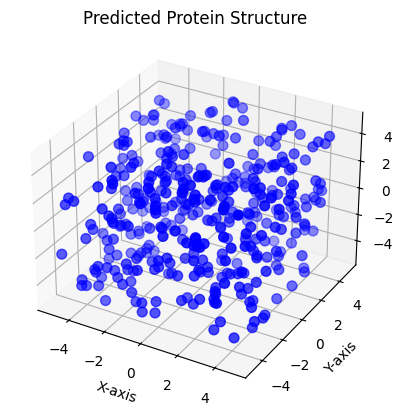

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract coordinates
positions = u.atoms.positions
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=50, c='b', marker='o')
ax.set_title("Predicted Protein Structure")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()


In [63]:
# Save the refined structure for use in OpenMM
u.atoms.write("openmm_input.pdb")


In [64]:
import MDAnalysis as mda

# Load the reference structure (ensure the file exists at the specified path)
ref = mda.Universe("data/4jrb.pdb")

# Verify it's loaded correctly
print(ref)


<Universe with 3303 atoms>


In [65]:
# Shift residue IDs of the predicted structure to start from 0
for residue in u.residues:
    residue.resid -= 1

# Verify the change
print("Updated Predicted Residues:", u.select_atoms("name CA").residues[:10])


Updated Predicted Residues: <ResidueGroup [<Residue ALA, 0>, <Residue ALA, 1>, <Residue ALA, 2>, <Residue ALA, 3>, <Residue ALA, 4>, <Residue ALA, 5>, <Residue ALA, 6>, <Residue ALA, 7>, <Residue ALA, 8>, <Residue ALA, 9>]>


In [66]:
# Replace predicted residue names with reference residue names
for pred_res, ref_res in zip(u.residues, ref.residues):
    pred_res.resname = ref_res.resname

# Verify the change
print("Updated Predicted Residue Names:", u.select_atoms("name CA").residues[:10])


Updated Predicted Residue Names: <ResidueGroup [<Residue HIS, 0>, <Residue MET, 1>, <Residue SER, 2>, <Residue LYS, 3>, <Residue GLY, 4>, <Residue GLU, 5>, <Residue GLU, 6>, <Residue LEU, 7>, <Residue PHE, 8>, <Residue THR, 9>]>


In [67]:
# Trim predicted structure to match reference residues
pred_trimmed = u.select_atoms("name CA and resid 0:397")

# Confirm the trimmed residue count
print("Trimmed Predicted Residues:", pred_trimmed.n_atoms)


Trimmed Predicted Residues: 397


In [68]:
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD

# Align the predicted structure to the reference
aligner = AlignTraj(u, ref, select="name CA and resid 0:397")
aligner.run()

# Recalculate RMSD
ref_ca = ref.select_atoms("name CA")
rmsd = RMSD(pred_trimmed, ref_ca)
rmsd.run()

# Print RMSD result
print("RMSD:", rmsd.rmsd)


SelectionError: Reference and trajectory atom selections do not contain the same number of atoms: 
atoms:    N_ref=230, N_traj=397
and also not the same number of residues:
residues: N_ref=230, N_traj=397

In [39]:
# Print the number of selected atoms and residues for debugging
print(f"Reference atom count: {ref.select_atoms('name CA and resid 0:230').n_atoms}")
print(f"Predicted atom count: {u.select_atoms('name CA and resid 0:230').n_atoms}")

print(f"Reference residue count: {ref.select_atoms('name CA and resid 0:230').n_residues}")
print(f"Predicted residue count: {u.select_atoms('name CA and resid 0:230').n_residues}")


Reference atom count: 224
Predicted atom count: 227


In [31]:
# Select only the first 230 residues from the predicted structure
pred_ca = u.select_atoms("name CA and resid 0:229")
ref_ca = ref.select_atoms("name CA and resid 0:229")


In [32]:
# Shift residue IDs in the predicted structure to start from 0
for residue in u.residues:
    residue.resid -= 1


In [40]:
print(f"Reference atom count: {ref_ca.n_atoms}")
print(f"Predicted atom count: {pred_ca.n_atoms}")


Reference atom count: 224
Predicted atom count: 227


In [41]:
# Adjust the predicted structure to match the reference
pred_ca = u.select_atoms(f"name CA and resid 0:{ref_ca.n_residues - 1}")

# Confirm the adjusted atom counts
print(f"Adjusted Predicted atom count: {pred_ca.n_atoms}")
print(f"Reference atom count: {ref_ca.n_atoms}")


Adjusted Predicted atom count: 224
Reference atom count: 224


In [35]:
# Align residue IDs by shifting predicted structure IDs
for residue in u.residues:
    residue.resid -= 1

# Verify the alignment
print("Updated Predicted Residue IDs:", u.select_atoms("name CA").residues[:10])


Updated Predicted Residue IDs: <ResidueGroup [<Residue HIS, -3>, <Residue MET, -2>, <Residue SER, -1>, <Residue LYS, 0>, <Residue GLY, 1>, <Residue GLU, 2>, <Residue GLU, 3>, <Residue LEU, 4>, <Residue PHE, 5>, <Residue THR, 6>]>


In [42]:
# Match residue IDs by shifting predicted residue IDs to align with the reference
for residue in u.residues:
    residue.resid -= 1


In [43]:
print(f"Trimmed Reference atom count: {ref_ca.n_atoms}")
print(f"Trimmed Predicted atom count: {pred_ca.n_atoms}")

print(f"Trimmed Reference residue count: {ref_ca.n_residues}")
print(f"Trimmed Predicted residue count: {pred_ca.n_residues}")


Trimmed Reference atom count: 224
Trimmed Predicted atom count: 224
Trimmed Reference residue count: 224
Trimmed Predicted residue count: 224


In [45]:
# Ensure atom names match
print("Reference atom names:", ref_ca.names[:10])
print("Predicted atom names:", pred_ca.names[:10])


Reference atom names: ['CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA']
Predicted atom names: ['CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA' 'CA']


In [49]:
from MDAnalysis.analysis.rms import RMSD

# Increase mass tolerance
rmsd = RMSD(pred_ca, ref_ca, tol_mass=0.5)
rmsd.run()

print("RMSD:", rmsd.rmsd)


RMSD: [[ 0.          0.         17.17856243]]


In [47]:
from MDAnalysis.analysis.rms import RMSD

# Recalculate RMSD after adjustments
rmsd = RMSD(pred_ca, ref_ca)
rmsd.run()

print("Final RMSD:", rmsd.rmsd)


Final RMSD: [[ 0.          0.         17.17856243]]


In [50]:
from MDAnalysis.analysis.align import AlignTraj

# Align predicted structure to reference
aligner = AlignTraj(u, ref, select="name CA")
aligner.run()

# Recalculate RMSD
from MDAnalysis.analysis.rms import RMSD

rmsd = RMSD(pred_ca, ref_ca)
rmsd.run()
print("Aligned RMSD:", rmsd.rmsd)


SelectionError: Reference and trajectory atom selections do not contain the same number of atoms: 
atoms:    N_ref=398, N_traj=397
and also not the same number of residues:
residues: N_ref=398, N_traj=397

In [51]:
# Select specific residues or regions (e.g., residues 10 to 50)
ref_region = ref.select_atoms("name CA and resid 10:50")
pred_region = u.select_atoms("name CA and resid 10:50")

# Recalculate RMSD for the region
rmsd = RMSD(pred_region, ref_region)
rmsd.run()
print("Regional RMSD:", rmsd.rmsd)


Regional RMSD: [[ 0.          0.         13.03410778]]


In [52]:
# Save the aligned predicted structure
u.atoms.write("aligned_predicted_structure.pdb")
ref.atoms.write("aligned_reference_structure.pdb")


In [53]:
from MDAnalysis.analysis.rms import rmsd

# Calculate RMSD for each residue
ref_positions = ref_ca.positions
pred_positions = pred_ca.positions

residue_rmsd = rmsd(pred_positions, ref_positions, superposition=True)
print("Per-residue RMSD:", residue_rmsd)


Per-residue RMSD: 17.178562428518266


In [54]:
# Compare sequences
ref_seq = "".join(ref_ca.residues.resnames)
pred_seq = "".join(pred_ca.residues.resnames)

print("Reference Sequence:", ref_seq)
print("Predicted Sequence:", pred_seq)


Reference Sequence: HISMETSERLYSGLYGLUGLULEUPHETHRGLYVALVALPROILELEUVALGLULEUASPGLYASPVALASNGLYHISLYSPHESERVALSERGLYGLUGLYGLUGLYASPALATHRTYRGLYLYSLEUTHRLEULYSPHEILECYSTHRTHRGLYLYSLEUPROVALPROTRPPROTHRLEUVALTHRTHRPHEVALGLNCYSPHEALAARGTYRPROASPHISMETLYSGLNHISASPPHEPHELYSSERALAMETPROGLUGLYTYRVALGLNGLUARGTHRILEPHEPHELYSASPASPGLYASNTYRLYSTHRARGALAGLUVALLYSPHEGLUGLYASPTHRLEUVALASNARGILEGLULEULYSGLYILEASPPHELYSGLUASPGLYASNILELEUGLYHISLYSLEUGLUTYRASNTYRASNSERHISASNVALTYRILEMETALAASPLYSGLNLYSASNGLYILELYSVALASNPHELYSILEARGHISASNILEGLUASPGLYSERVALGLNLEUALAASPHISTYRGLNGLNASNTHRPROILEGLYASPGLYPROVALLEULEUPROASPASNHISTYRLEUSERTHRGLNSERALALEUSERLYSASPPROASNGLULYSARGASPHISMETVALLEULEUGLUPHEVALTHRALA
Predicted Sequence: LYSGLYGLUGLULEUPHETHRGLYVALVALPROILELEUVALGLULEUASPGLYASPVALASNGLYHISLYSPHESERVALSERGLYGLUGLYGLUGLYASPALATHRTYRGLYLYSLEUTHRLEULYSPHEILECYSTHRTHRGLYLYSLEUPROVALPROTRPPROTHRLEUVALTHRTHRPHECR2VALGLNCYSPHEALAARGTYRPROASPHISMETLYSGLNHISASPPHEPHELYSSERALAMETPROGLUGLYTYRVALGLNGLUARGTHRILEPHEPH

In [ ]:
# Save structures for visualization
ref.write("reference_structure.pdb")
u.write("predicted_structure.pdb")
